#### 7

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006      
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,1,1)
var_sarpdq   <-  c(1,1,1)
var_drift   <-  FALSE
var_constant   <-  FALSE

var_char  <-  c(4,2)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
# gts_train  <- window(y, start=19, end=46)
# gts_test  <- window(y, start=47, end=54)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
         
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -23033.047  -4431.841   2077.968  -1552.524  -1437.112  10677.161
 [7]  12011.919  13867.241  19007.142  17248.609  14186.574   8003.399
[13] -11549.167   5205.127   8826.241   5608.646   3131.105  17933.942
[19]  24166.915  31399.907  28991.346  25052.315  23054.334  19310.484
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96 

In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -20059.207 -14756.288 -15213.073 -14420.064  -2704.151  10811.346
 [7]  11934.443   2607.366  -3801.178  -9898.610 -14878.659 -46536.807
[13] -25744.381 -19194.181 -21081.557 -20748.377  -8500.480   3093.233
[19]   5102.966  -5249.772 -12119.388 -17284.488 -24568.540 -55301.402

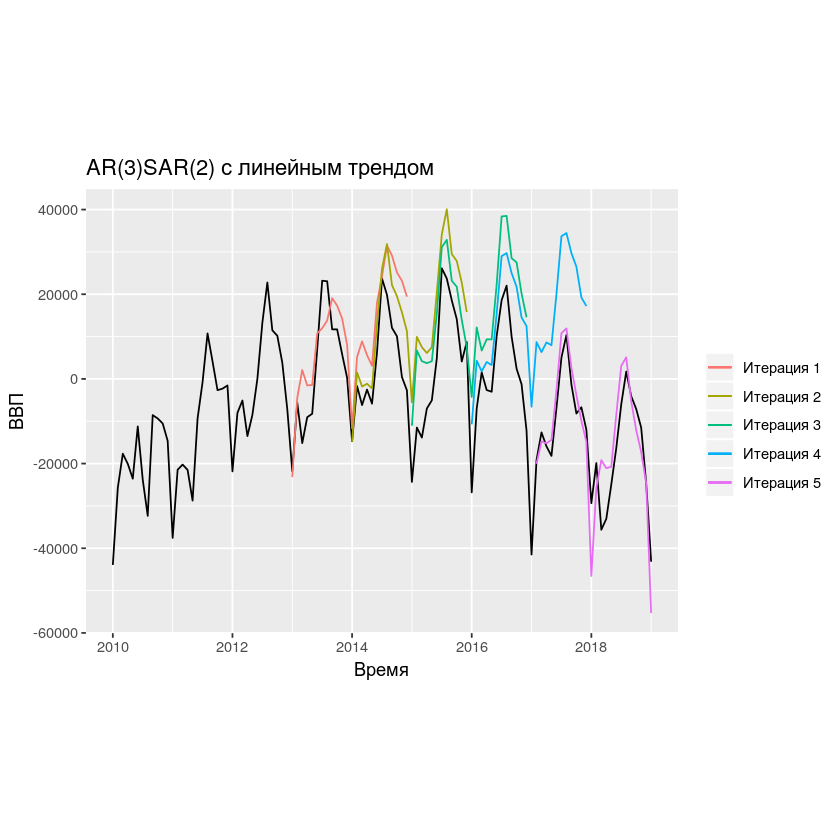

In [13]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [14]:
df_acc

ME,RMSE,MAPE,Iteration
-7752.4452,11262.558,470.86075,1
-10744.0373,12389.561,277.35529,13
-13476.4144,15139.373,259.78841,25
-19562.3857,21878.354,353.25501,37
-981.8668,7186.519,59.09882,50


In [15]:
colMeans(df_acc)

ME        RMSE        MAPE   Iteration 
-10503.4299  13571.2728    284.0717     25.2000

In [16]:
df_mean_acc <- readRDS("df_mean_acc.rds")
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,69.75467,322.2364,NA
2 level (state),69.73105,322.2966,NA
2 level (type),68.82769,322.3154,NA
2 level (clusetered),70.06872,318.5989,NA


In [17]:
df_mean_acc[2,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,69.75467,322.2364,13571.27
2 level (state),69.73105,322.2966,NA
2 level (type),68.82769,322.3154,NA
2 level (clusetered),70.06872,318.5989,NA


In [18]:
df_acc

ME,RMSE,MAPE,Iteration
-7752.4452,11262.558,470.86075,1
-10744.0373,12389.561,277.35529,13
-13476.4144,15139.373,259.78841,25
-19562.3857,21878.354,353.25501,37
-981.8668,7186.519,59.09882,50


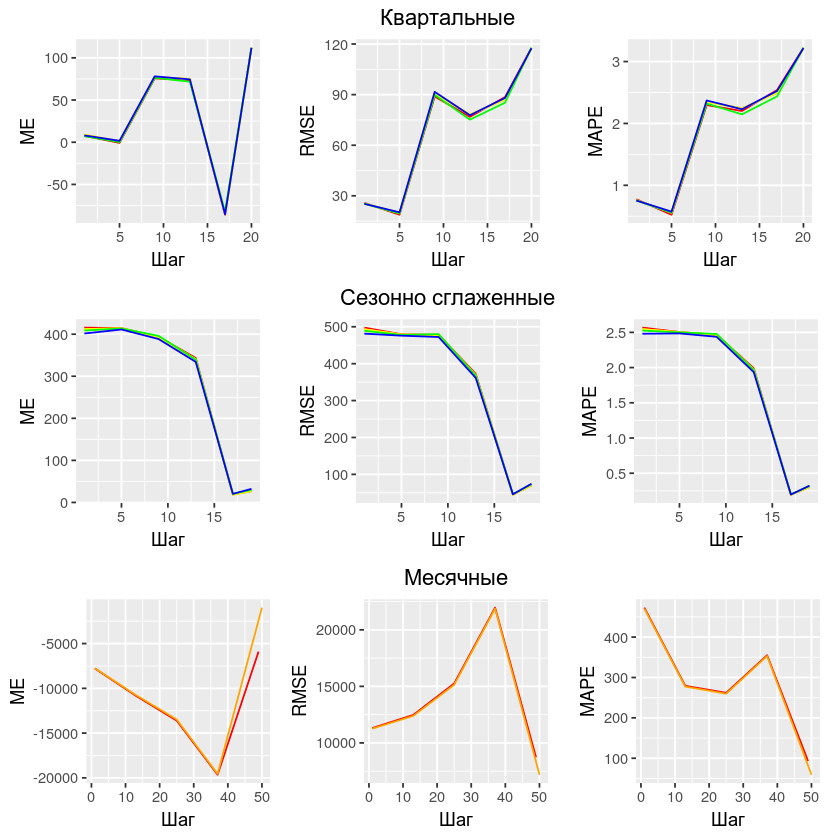

In [19]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [20]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [21]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [22]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [23]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    
    allts <- aggts(gts_train)

    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
         

    
    
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -23083.394  -4444.422   2081.728  -1549.494  -1444.784  10690.630
 [7]  11995.776  13848.748  19028.334  17249.402  14204.740   8015.855
[13] -11591.606   5202.501   8826.880   5612.183   3120.010  17953.076
[19]  24184.174  31427.866  29027.908  25071.740  23080.976  19336.114
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -14796.877   1526.990  -1810.117  -1132.191  -2257.136  13004.968
 [7]  25949.917  31737.389  22086.370  19485.323  15660.028  11202.300
[13]  -5532.579   9870.831   7447.354   6085.890   7452.284  20352.859
[19]  34019.463  39890.017  29374.766  27742.297  22638.944  15735.981
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -11064.354   6639.816   4123.278   3670.759   4114.053  15370.085
 [7]  30977.197  32695.774  23076.694  21669.158  13876.352   7456.331
[13]  -4291.923  12063.824   6634.428   9271.019   9248.846  22088.294
[19]  38162.115  38314.792  28366.880  27392.439  20045.294  14469.818
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -10717.614   4251.492   1763.902   3957.697   3248.596  15283.597
 [7]  28902.986  29629.380  24904.648  21684.123  14433.268  12410.244
[13]  -6587.597   8612.776   6270.773   8557.903   7896.147  19948.354
[19]  33588.922  34325.501  29610.215  26389.795  19141.384  17133.726
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -19997.997 -14708.694 -15153.954 -14369.747  -2674.408  10815.687
 [7]  11942.318   2635.410  -3756.019  -9838.285 -14811.676 -46381.953
[13] -25625.018 -19101.559 -20967.087 -20642.727  -8434.854   3141.166
[19]   5146.013  -5166.614 -12006.386 -17168.623 -24412.183 -55044.514
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [24]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [25]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [26]:
df_acc

ME,RMSE,MAPE,Iteration
-7756.1225,11274.798,471.40708,1
-10770.7530,12416.644,278.02112,13
-13507.8738,15169.189,260.38545,25
-19581.0925,21895.932,353.69549,37
-957.2206,7195.002,59.15224,50


In [27]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -20059.207 -14756.288 -15213.073 -14420.064  -2704.151  10811.346
 [7]  11934.443   2607.366  -3801.178  -9898.610 -14878.659 -46536.807
[13] -25744.381 -19194.181 -21081.557 -20748.377  -8500.480   3093.233
[19]   5102.966  -5249.772 -12119.388 -17284.488 -24568.540 -55301.402

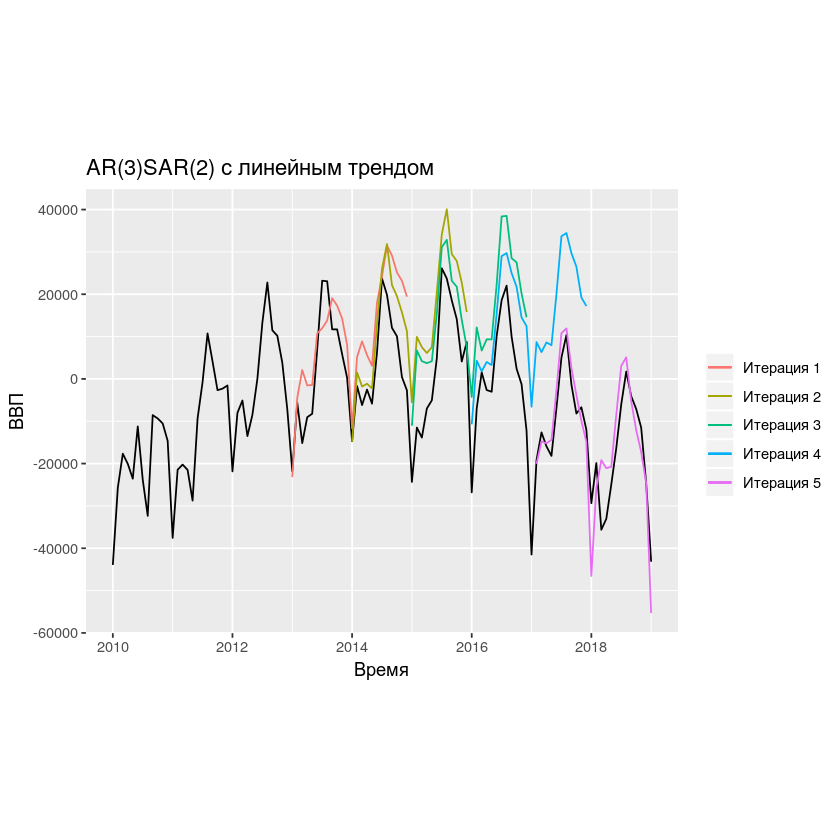

In [28]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [29]:
colMeans(df_acc)

ME        RMSE        MAPE   Iteration 
-10514.6125  13590.3131    284.5323     25.2000

In [30]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [31]:
df_mean_acc[3,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,69.75467,322.2364,13571.27
2 level (state),69.73105,322.2966,13590.31
2 level (type),68.82769,322.3154,NA
2 level (clusetered),70.06872,318.5989,NA


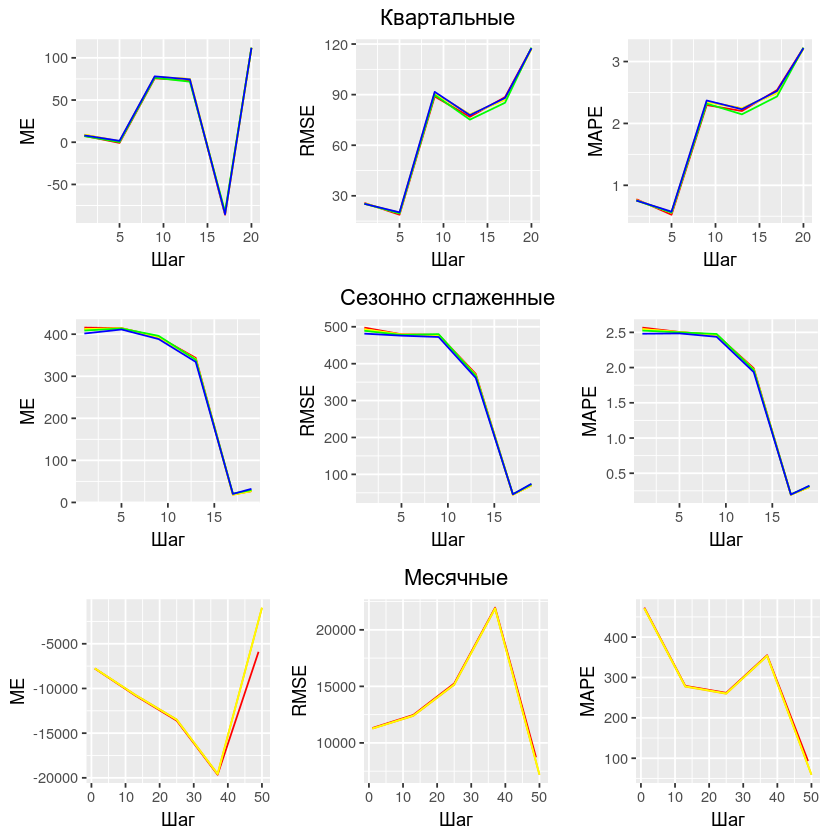

In [32]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [33]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_type.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [34]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [35]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [36]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    
    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
         

     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -19291.9676  -1761.2171   2617.8364   -600.8495   1126.3752  10785.3256
 [7]  13791.6512  15255.8577  17916.2861  18470.6043  13841.0143   7368.6470
[13]  -7231.2259   7756.8230  10115.6730   7719.2917   6059.8374  18319.1384
[19]  23999.9564  29974.6893  27870.8045  25084.3932  22980.5425  19304.5762
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -13221.1258    904.6978  -3024.6386   -907.8399  -1611.3033  11743.8375
 [7]  27046.2793  30721.6547  20203.8826  20515.6526  14272.1661  10391.5927
[13]  -3087.2684   8419.9871   5833.5683   6483.2638   7447.9441  18164.8599
[19]  34914.0000  37859.4035  26711.8561  29002.7965  20419.0029  15326.7552
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -10273.471   5060.205   2628.268   3406.673   3145.591  13252.696
 [7]  30496.514  29880.213  21397.840  20578.909  10678.985   6892.180
[13]  -3722.598   9681.452   5189.901   8694.433   8071.952  18729.021
[19]  37041.339  34468.545  26177.153  26104.646  15580.034  13619.862
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -11724.110   1620.677   1052.492   2572.986   1139.570  14593.648
 [7]  28216.009  27903.200  23657.927  19932.083  12331.923  11907.661
[13]  -7909.149   5391.078   4810.268   6795.580   5638.453  18381.527
[19]  32681.300  32025.364  27983.656  24557.676  16316.593  16567.961
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -18878.7261 -15606.8272 -15014.5506 -13633.8629  -4747.0557  11182.2175
 [7]  11030.2957    862.9009  -2970.0706 -10876.2882 -15599.1590 -44903.1795
[13] -25603.1673 -20011.4411 -20856.0666 -20723.9330 -10419.0938   3328.2847
[19]   3766.1437  -6746.5245 -11272.4567 -18523.1993 -24105.2355 -52390.8025
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [37]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [38]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [39]:
df_acc

ME,RMSE,MAPE,Iteration
-8740.6693,11602.31,476.96785,1
-10303.9177,11836.23,256.27073,13
-11941.5976,13786.50,224.13343,25
-17989.5990,20430.15,323.21564,37
-701.8001,6785.36,51.39092,50


In [40]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -20059.207 -14756.288 -15213.073 -14420.064  -2704.151  10811.346
 [7]  11934.443   2607.366  -3801.178  -9898.610 -14878.659 -46536.807
[13] -25744.381 -19194.181 -21081.557 -20748.377  -8500.480   3093.233
[19]   5102.966  -5249.772 -12119.388 -17284.488 -24568.540 -55301.402

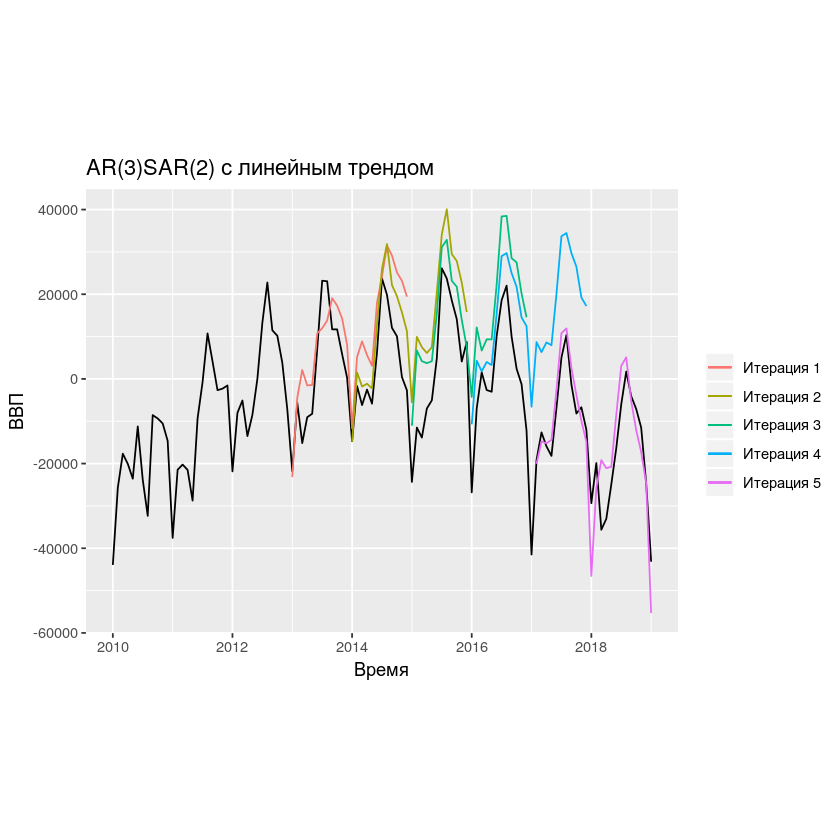

In [41]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [42]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-9935.5167 12888.1107   266.3957    25.2000

In [43]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [44]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,69.75467,322.2364,13571.27
2 level (state),69.73105,322.2966,13590.31
2 level (type),68.82769,322.3154,NA
2 level (clusetered),70.06872,318.5989,NA


In [45]:
df_mean_acc[4,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,69.75467,322.2364,13571.27
2 level (state),69.73105,322.2966,13590.31
2 level (type),68.82769,322.3154,12888.11
2 level (clusetered),70.06872,318.5989,NA


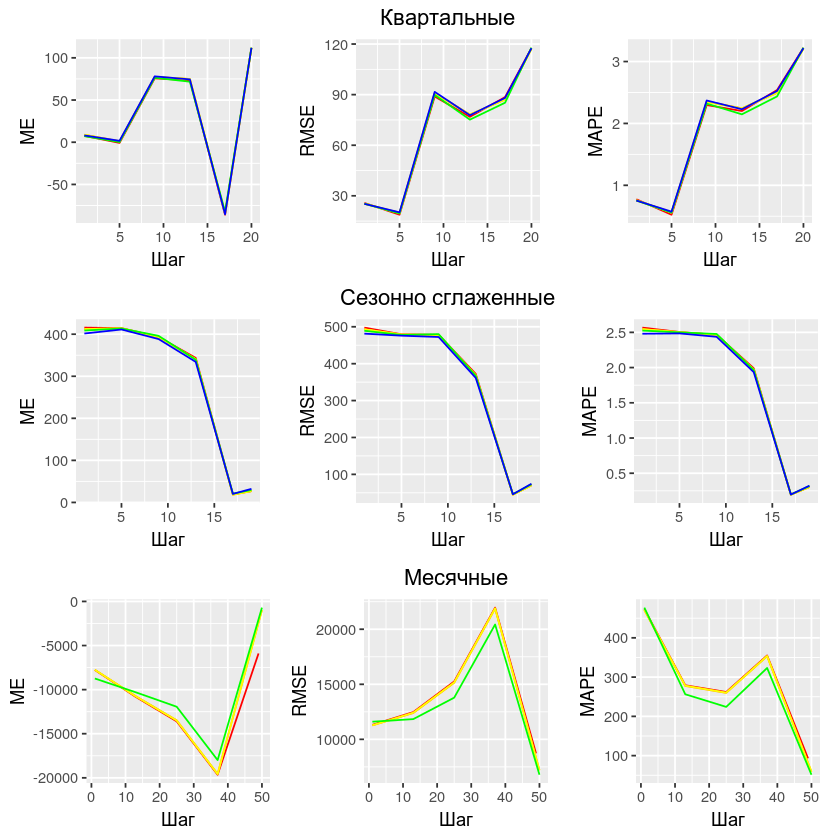

In [46]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [47]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_clust.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [48]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [49]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [50]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
         
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -22488.699  -4306.702   2074.603  -1464.681  -1314.000  10651.128
 [7]  12282.739  14022.677  18949.714  17432.082  14059.680   7956.841
[13] -11041.205   5315.749   8928.478   5768.708   3340.720  17945.593
[19]  24177.465  31204.102  28851.103  25042.136  22953.665  19259.606
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -14644.890   1146.392  -2000.996  -1334.142  -2442.702  12749.744
 [7]  25744.708  31295.741  21681.720  19220.667  15291.985  10905.808
[13]  -5552.242   9339.889   7043.480   5719.272   7084.023  19800.247
[19]  33522.365  39125.005  28677.629  27266.222  22021.761  15329.174
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -11076.356   6342.445   3921.760   3514.101   3920.719  15045.271
 [7]  30789.992  32231.781  22753.497  21396.696  13357.277   7274.912
[13]  -4385.510  11621.282   6377.520   9027.106   8995.354  21547.737
[19]  37793.069  37674.739  27917.407  27048.142  19364.339  14202.875
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -10815.966   3856.074   1708.206   3764.015   2942.139  15263.444
 [7]  28856.025  29409.656  24753.116  21444.237  14136.157  12377.517
[13]  -6772.288   8125.810   6092.150   8295.929   7593.094  19765.593
[19]  33489.415  34033.769  29384.349  26150.626  18756.267  17065.620
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -19798.507 -14576.420 -15014.363 -14086.536  -2605.794  10861.537
 [7]  12064.850   2591.750  -3617.151  -9727.172 -14772.032 -45948.574
[13] -25320.129 -18895.629 -20717.134 -20300.065  -8322.738   3254.024
[19]   5268.939  -5106.909 -11739.977 -16960.152 -24089.660 -54236.374
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [51]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [52]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [53]:
df_acc

ME,RMSE,MAPE,Iteration
-7829.313,11244.223,469.85285,1
-10406.411,12050.376,269.35098,13
-13186.423,14868.448,253.71739,25
-19374.206,21699.528,349.30272,37
-1156.699,7144.649,59.22024,50


In [54]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -20059.207 -14756.288 -15213.073 -14420.064  -2704.151  10811.346
 [7]  11934.443   2607.366  -3801.178  -9898.610 -14878.659 -46536.807
[13] -25744.381 -19194.181 -21081.557 -20748.377  -8500.480   3093.233
[19]   5102.966  -5249.772 -12119.388 -17284.488 -24568.540 -55301.402

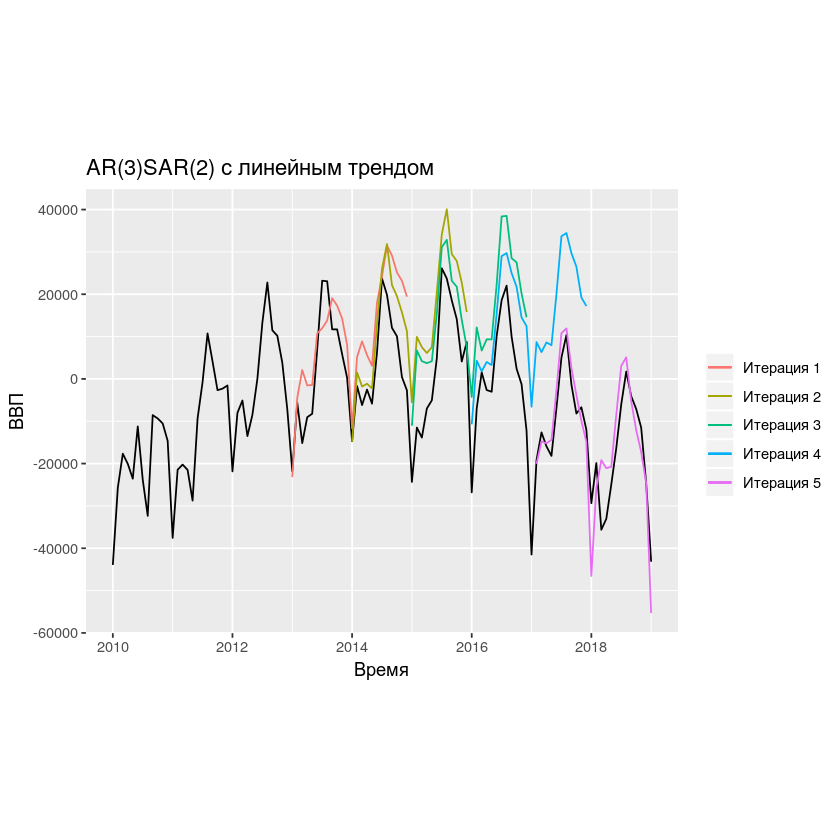

In [55]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [56]:
colMeans(df_acc)

ME        RMSE        MAPE   Iteration 
-10390.6105  13401.4447    280.2888     25.2000

In [57]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [58]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,69.75467,322.2364,13571.27
2 level (state),69.73105,322.2966,13590.31
2 level (type),68.82769,322.3154,12888.11
2 level (clusetered),70.06872,318.5989,NA


In [59]:
df_mean_acc[5,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,69.75467,322.2364,13571.27
2 level (state),69.73105,322.2966,13590.31
2 level (type),68.82769,322.3154,12888.11
2 level (clusetered),70.06872,318.5989,13401.44


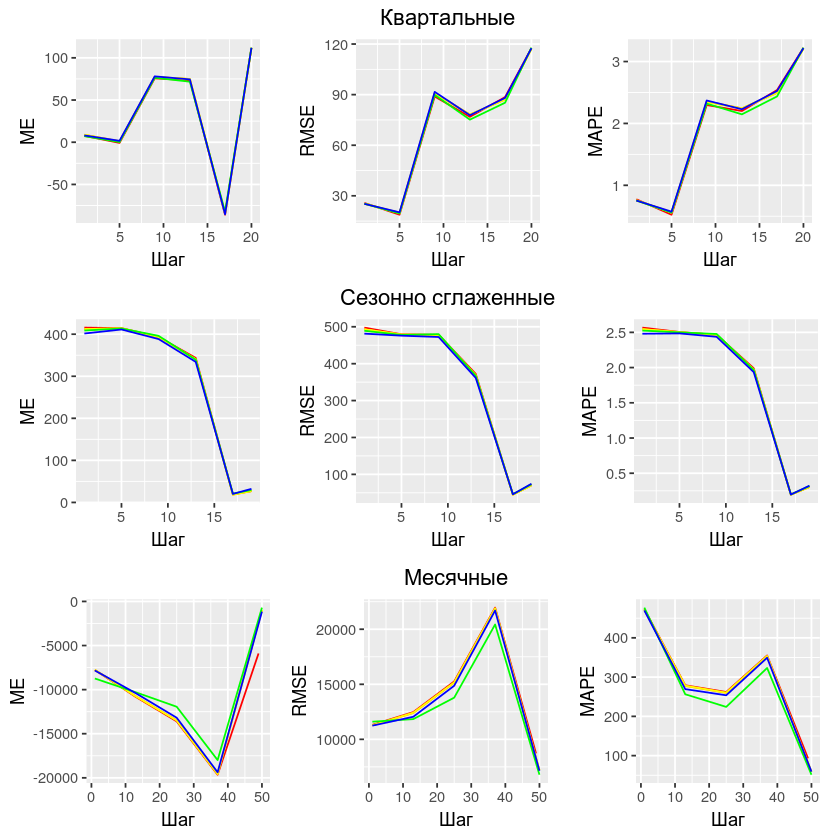

In [60]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [61]:
saveRDS(df_mean_acc, "df_mean_acc.rds")
saveRDS(plots_test_all, "plots_test_not_all.rds")